In [1]:
URL = "localhost:5432"
BUCKET_ID = 853
DATA_FILE = f"joined{BUCKET_ID}"
DATA_PATH = f'./data/{DATA_FILE}'

# Should be configurable
SHOULD_MATCH = lambda matching, total: matching / total > 0.5
SHOULD_MERGE = lambda matching, total: matching > 5 or matching / total >= 0.2

# Setup


In [2]:
import pandas as pd
import numpy as np
import graph_tool.all as gt
from sqlalchemy import create_engine
import re
from tqdm import tqdm


In [3]:
try:
    ev = pd.read_feather(DATA_PATH + '.feather')
except FileNotFoundError:
    db = create_engine(
        f"postgresql://postgres:password@{URL}/debate-cards").connect()
    ev = pd.read_sql("""
      SELECT id, gid, tag, cite, fullcite, fulltext, markup, pocket, hat, block, "fileId" FROM public."Evidence" 
      WHERE "bucketId" = {0};
    """.format(BUCKET_ID), db)
    print("Loaded from database")

    SENTENCE_REGEX = r'[.?!]+(?=\d*\s+[a-zA-Z])'
    cutoff = 20
    ev['sentences'] = ev.fulltext.str \
        .split(SENTENCE_REGEX) \
        .map(lambda l: list(map(lambda s: re.sub(r'[^a-zA-Z]', '', s), l))) \
        .map(lambda l: list(filter(lambda s: len(s) >= cutoff, l)))
    print("Sentences added")

    ev.to_feather(DATA_PATH + '.feather')


Utility function to display list of cards as HTML

In [4]:
from IPython.display import HTML
parentStyles = """
  margin: 50px; 
  height: 500px; 
  display: flex;
  overflow-x: scroll;
"""
childStyles = """"
  padding: 10px;
  flex-shrink: 0;
  flex-basis: 200px;
  overflow: scroll;
"""


def showCards(cards: pd.DataFrame, showIds = False, fileName=None):
    markups = cards.to_dict()['markup'].values()
    headers = [f"<h2>{id}</h2>" if showIds else "" for id in cards.id]
    divs = "\n".join(
        [f"<div style='{childStyles}'>{headers[i]}{markup}</div>" for i, markup in enumerate(markups)])
    html = HTML(f"<div style='{parentStyles}'>{divs}</div>")
    if fileName is None:
      return html
    
    path = DATA_PATH + fileName + '.html'
    with open(path, 'w') as f:
      f.write(str(html.data))
    return HTML(f"<a href={path}>Open</a>")


# Build incremental


Implementation is probably scuffed and inefficient, but its just a prototype

Initilize global things. `bucketMap` and `sentenceMap` would probably be stored in redis

In [5]:
bucketMap: "dict[int, Bucket]" = {}
processQueue: list[int] = []
sentenceMap = {}
log = []

## Card Matching

Reimplementation of things from main repo

In [6]:
INSIDE_TOLERANCE = 2
EDGE_TOLERANCE = 1

# Should always call as "checkMatch(a, b) or checkMatch(b, a)" so commutivity works
def checkMatch(a, b):
    aLen, aMin, aMax = a
    bLen, bMin, bMax = b
    insideMatch = (aLen > 3 and (aLen - (aMax + 1 - aMin) <= INSIDE_TOLERANCE))
    edgeMatch =  (aMin <= EDGE_TOLERANCE and bLen - bMax <= EDGE_TOLERANCE)
    return insideMatch or edgeMatch

In [7]:
def filterMatches(id: int, cardMatches):
    matching = []
    # Apparently this is needed for decent performance
    aLen = len(ev.loc[id].sentences)
    bLens = [len(s) for s in ev.loc[cardMatches.keys()].sentences]
    
    for i, (matchId, matchingSentences) in enumerate(cardMatches.items()):
        aIndexes = [match['aIndex'] for match in matchingSentences]
        bIndexes = [match['bIndex'] for match in matchingSentences]
        aMin, aMax, bMin, bMax = min(aIndexes), max(
            aIndexes), min(bIndexes), max(bIndexes)
        bLen = bLens[i]
        # bLen = len(ev.loc[matchId].sentences)
        aInfo = (aLen, aMin, aMax)
        bInfo = (bLen, bMin, bMax)
        if (checkMatch(aInfo, bInfo) or checkMatch(bInfo, aInfo)):
            matching.append(matchId)

    return matching

In [8]:
def getMatches(id: int) -> list[int]:
    sentences = ev.loc[id].sentences
    cardMatches = {}
    # Get cards with any sentence and common and record the index of sentences that matched in both cards
    for sentenceI, s in enumerate(sentences):
        sentenceMatches = sentenceMap[s] if s in sentenceMap else []
        for match in sentenceMatches:
            if match['cardId'] == id:
                continue
            if not match['cardId'] in cardMatches:
                cardMatches[match['cardId']] = []
            cardMatches[match['cardId']].append(
                {"aIndex": sentenceI, "bIndex": match['index']})
    return filterMatches(id, cardMatches)


## Buckets

In [20]:
from collections import Counter

class Bucket:
    def __init__(self, root: int, matches: "list[int]"):
        self.root = root
        self.cards = Counter({root: 1}) # Cards in the bucket, with a count of how many other cards in the bucket they match
        self.matching = Counter(matches) # Cards not in the bucket that match some cards in the bucket, with a count of how many they match
        del self.matching[root]
        self.bucketSet = BucketSet([self])
        bucketMap[root] = self
    
    
    @property
    def size(self):
        return len(self.cards)

    def removeCard(self, cardId: int):
        del self.cards[cardId]
        del bucketMap[cardId]
        # Decrement match count for things that had matched this card
        # Storing this would take a ton of work, so its probably best to just recalculate matches
        matches = getMatches(cardId)
        for match in matches:
            counter = self.cards if match in self.cards else self.matching
            if counter[match] <= 1: del counter[match]
            else: counter[match] -= 1

    # Remove cards that no longer belong and update bucketSet
    def resolve(self, updates: list[int]):
        if len(self.cards) == 0: return
        
        updates = [u for u in updates if u in bucketMap] # Filter out things that arent assigned to a bucket
        for id, count in self.cards.items():
            # If card no longer belongs
            if not SHOULD_MATCH(count, self.size):
                # Remove from bucket and send to be reprocessed later, easier than finding new bucket now
                self.removeCard(id)
                processQueue.append(id)
                # Stop looping and restart in case something else now dosent belong
                return self.resolve(updates)
        self.bucketSet.resolve()

        # Cards that just moved from below threshold to above
        newMatches = [id for id in updates if SHOULD_MERGE(self.matching[id], self.size)
         and not SHOULD_MERGE(self.matching[id] - 1, self.size)]
        setMatching = self.bucketSet.matching
        setSize = self.bucketSet.size
        newSetMatches = [id for id in updates if SHOULD_MERGE(setMatching[id], setSize) 
         and not SHOULD_MERGE(setMatching[id] - 1, setSize)]
        
        newMatchBuckets = set([bucketMap[id] for id in newMatches + newSetMatches])
        for bucket in newMatchBuckets:
            # print(self.root, self.bucketSet, bucket.root, bucket.bucketSet)
            if bucket.bucketSet != self.bucketSet and self.bucketSet.shouldAdd(bucket):
                self.bucketSet.merge(bucket.bucketSet)
        return

    def addCard(self, cardId: int, matches: list[int]):
        del self.matching[cardId]  # Clear from matches not in bucket
        if cardId in self.cards:
            print(f"Warning: {cardId} already in bucket with root {self.root}")
            return

        matchCount = 1 # Matches self, so start at 1
        for match in matches:
            if match in self.cards:
                matchCount += 1
                self.cards[match] += 1
            else:
                self.matching[match] += 1

        self.cards[cardId] = matchCount
        self.root = min(self.root, cardId)
        bucketMap[cardId] = self

    def addMatches(self, cardId: int, matches: list[int]):
        self.matching[cardId] += len(np.intersect1d(matches, list(self.cards)))

    def bucketMatches(self, matches: list[int]):
      return SHOULD_MATCH(len(np.intersect1d(matches, list(self.cards))), self.size)

    def __repr__(self) -> str:
        return f"Bucket(Root: {self.root}, Size: {self.size}, Cards: {self.cards}, Matching: {self.matching})"

In [10]:
from functools import reduce

bucketSetStr = lambda b: "[\n\t" + "\n\t".join(map(str, b)) + "\n]"

def checkAdd(a: "Bucket | BucketSet", b: "Bucket | BucketSet"):
  matchTotals = a.matching
  matchCount = len([c for c in b.cards if SHOULD_MERGE(matchTotals[c], a.size)])
  return SHOULD_MERGE(matchCount, b.size)

class BucketSet:
  buckets: set[Bucket]

  def __init__(self, buckets: list[Bucket] | set[Bucket]):
    self.buckets = set(buckets)

  @property
  def size(self):
    return sum([len(b.cards) for b in self.buckets])

  @property
  def matching(self):
    return reduce(lambda total, b: total + b.matching, self.buckets, Counter())
  
  @property
  def cards(self):
    return reduce(lambda total, b: total + b.cards, self.buckets, Counter())

  @property
  def root(self):
    return min([b.root for b in self.buckets])

  def merge(self, bucketSet: "BucketSet"):
    print(f"Merging {bucketSet.root} into {self.root}")
    # print(f"{bucketSetStr(bucketSet.buckets)}\n{bucketSetStr(self.buckets)}\n")
    self.buckets = self.buckets.union(bucketSet.buckets)
    for bucket in bucketSet.buckets:
      bucket.bucketSet = self
  
  # Check if would merge into entire bucketSet or any individual bucket
  def shouldAdd(self, other: "Bucket"):
    return checkAdd(self, other) or any([checkAdd(b, other) for b in self.buckets])

  # Fine if inefficient since its running on small number of values
  def resolve(self):
    if len(self.buckets) < 2: return
    for bucket in self.buckets:
      # Check if bucket would still get added if you tried now
      if not BucketSet([b for b in self.buckets if b != bucket]).shouldAdd(bucket):
        print(f"Removing {bucket.root} from {self.root}")
        # print(self, "\n")
        self.buckets.remove(bucket)
        bucket.bucketSet = BucketSet([bucket])
        # Stop lopping and restart in case something else now dosent belong
        return self.resolve()

  def __repr__(self) -> str:
        return f"BucketSet(root: {self.root}, buckets: {self.buckets})"

In [11]:
def processCard(id: int, card: pd.Series):
    matching = getMatches(id)

    matchBuckets = set([bucketMap[s] for s in matching if s in bucketMap])
    matchedBuckets = [b for b in matchBuckets if b.bucketMatches(matching)]
    [b.addMatches(id, matching) for b in matchBuckets]
    if len(matchedBuckets) == 0:
        addBucket = Bucket(id, matching)
        matchBuckets.add(addBucket)
    else:
        addBucket = max(matchedBuckets, key=lambda b: b.size)
        addBucket.addCard(id, matching)

    addBucket.resolve(matching)
    for i, s in enumerate(card['sentences']):
        if not s in sentenceMap:
            sentenceMap[s] = []
        sentenceMap[s].append({"cardId": id, "index": i})


In [21]:
import random
sentenceMap = {}
processQueue = []
bucketMap = {}
log = []
for id, card in ev.iterrows():
    processQueue.append(id)
processQueue = sorted(processQueue) # Makes debugging easier
# print(processQueue)
# random.shuffle(processQueue)
for i, id in enumerate(tqdm(processQueue)):
    # print(id)
    # print(len(processQueue) - i)
    processCard(id, ev.loc[id])
bucketSet = set([b for b in bucketMap.values()])
bucketSetMap = {id: b.bucketSet for id, b in bucketMap.items()}
bucketSetSet = set([b.bucketSet for b in bucketSet])
len(bucketSet), len(bucketSetSet)

  2%|▏         | 105/6463 [00:00<00:13, 461.30it/s]

Merging 32 into 46
Removing 46 from 32
Merging 46 into 32
Merging 32 into 104


  3%|▎         | 212/6463 [00:00<00:13, 466.29it/s]

Merging 38 into 119
Removing 119 from 38
Merging 38 into 119


  5%|▌         | 344/6463 [00:00<00:16, 371.17it/s]

Merging 29 into 299
Removing 119 from 38
Merging 29 into 305


  8%|▊         | 523/6463 [00:01<00:18, 326.00it/s]

Merging 11 into 472


  9%|▊         | 556/6463 [00:01<00:21, 275.29it/s]

Merging 119 into 11


 27%|██▋       | 1775/6463 [00:12<00:13, 349.53it/s]

Merging 1707 into 1698


 32%|███▏      | 2090/6463 [00:15<00:44, 98.22it/s] 

Merging 1750 into 1680


 33%|███▎      | 2164/6463 [00:16<00:35, 121.11it/s]

Merging 1653 into 1680


 35%|███▌      | 2273/6463 [00:17<00:50, 82.93it/s] 

Merging 1644 into 2256


 37%|███▋      | 2377/6463 [00:19<01:04, 63.01it/s]

Merging 1698 into 2139


 40%|███▉      | 2580/6463 [00:20<00:10, 361.49it/s]

Merging 2455 into 2467
Removing 2139 from 1698


 40%|████      | 2616/6463 [00:20<00:15, 244.80it/s]

Merging 2609 into 1653
Merging 1498 into 2636


 42%|████▏     | 2739/6463 [00:21<00:32, 116.21it/s]

Merging 1498 into 2712


 49%|████▉     | 3152/6463 [00:26<00:29, 113.32it/s]

Merging 3123 into 32


 55%|█████▌    | 3580/6463 [00:28<00:08, 354.90it/s]

Merging 2489 into 2463
Removing 2489 from 2463


 61%|██████▏   | 3969/6463 [00:32<00:28, 88.98it/s] 

Merging 32 into 3955


 65%|██████▌   | 4218/6463 [00:36<00:27, 81.99it/s]

Merging 2489 into 4203


 65%|██████▌   | 4230/6463 [00:37<00:26, 84.28it/s]

Merging 1498 into 4227


 70%|███████   | 4529/6463 [00:40<00:24, 78.82it/s] 

Removing 2609 from 1653


 71%|███████   | 4576/6463 [00:41<00:46, 40.19it/s]

Merging 1498 into 4571


 85%|████████▌ | 5495/6463 [01:05<00:26, 36.24it/s]

Merging 3179 into 5492


 85%|████████▌ | 5520/6463 [01:06<00:28, 33.27it/s]

Merging 1498 into 5518


6469it [01:34, 68.30it/s]                          

Merging 29 into 774


(60, 39)

In [19]:
def printArr(arr: list[int]):
  return ", ".join([str(el) for el in arr])
printArr(sorted([len(b.cards) for b in bucketSet])), printArr(sorted([len(b.cards) for b in bucketSetSet]))

('1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 4, 4, 4, 5, 5, 7, 8, 9, 9, 12, 14, 15, 16, 17, 19, 21, 24, 26, 29, 31, 50, 62, 64, 65, 67, 71, 98, 137, 190, 192, 197, 266, 316, 332, 409, 453, 521, 1307, 1359',
 '1, 1, 1, 1, 1, 1, 2, 3, 3, 4, 5, 7, 8, 8, 10, 12, 16, 17, 19, 22, 26, 29, 50, 62, 65, 67, 71, 99, 137, 192, 197, 332, 342, 345, 436, 458, 521, 1364, 1528')

In [23]:
with open(DATA_PATH + "_incrMerge.html", "w") as f:
    for bucket in bucketSetSet:
        f.write(f"<h1>{bucket.root}</h1>")
        f.write(showCards(ev.loc[list(bucket.cards)], True).data)

In [24]:
with open(DATA_PATH + "_incrMerge_cites.txt", 'w') as f:
  for bucket in bucketSetSet:
    f.write(str(bucket.root) + "\t" + " // ".join(ev.loc[list(bucket.cards), 'cite'].values) + "\n")

# Graph


## Build


In [16]:
def genAdj():
  adj = np.zeros((len(ev), len(ev)))
  for id in tqdm(ev.index):
    adj[id, getMatches(id)] = 1
  return adj

In [17]:
def adjacencyToSimpleGt(adjacency):
    g = gt.Graph(directed=False)
    g.add_vertex(adjacency.shape[0])
    g.add_edge_list(np.transpose(adjacency.nonzero()))
    gt.remove_parallel_edges(g)
    gt.remove_self_loops(g)
    return g


In [25]:
try:
    bucketGraph = gt.load_graph(DATA_PATH + "_graph-tool.gt")
except FileNotFoundError:
    adj = genAdj()
    bucketGraph = adjacencyToSimpleGt(adj)
    bucketGraph.save(DATA_PATH + "_graph-tool.gt")
bucketGraph


<Graph object, undirected, with 6463 vertices and 2331434 edges, at 0x7faa0461eb10>

In [26]:
# In case using outdated match function, sometimes small unconnected components exist and make formatting weird
bucketGraph = gt.extract_largest_component(bucketGraph)

In [27]:
sfdp = gt.sfdp_layout(bucketGraph)

In [28]:
def drawBuckets(buckets, layout=sfdp):
  color = bucketGraph.new_vertex_property('double')
  bucketNums = {bucket.root: i for i, bucket in enumerate(set(buckets.values()))}
  for (id, bucket) in buckets.items(): color.a[id] = bucketNums[bucket.root]
  return gt.graph_draw(bucketGraph, pos=layout, vertex_fill_color=color, edge_color=[20/255, 20/255, 20/255, 1])


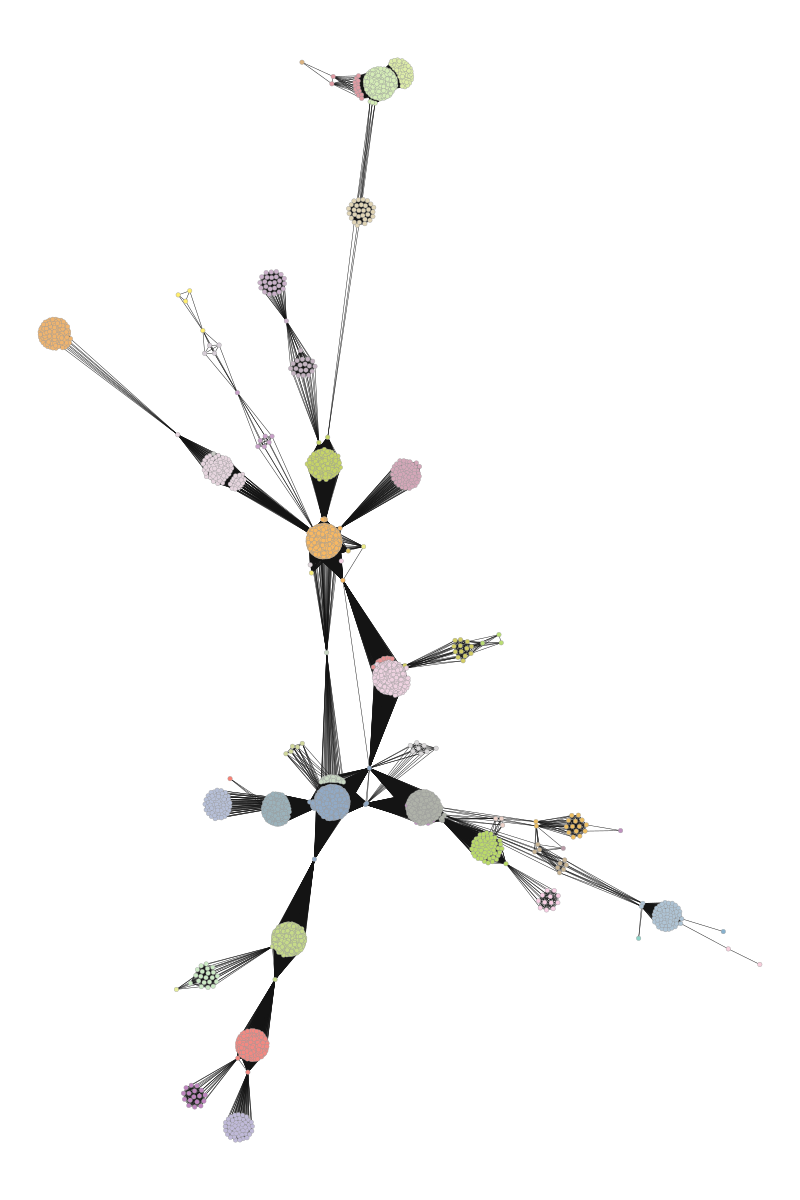

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7faa46057d50, at 0x7faa033fa650>

In [29]:
drawBuckets(bucketMap)

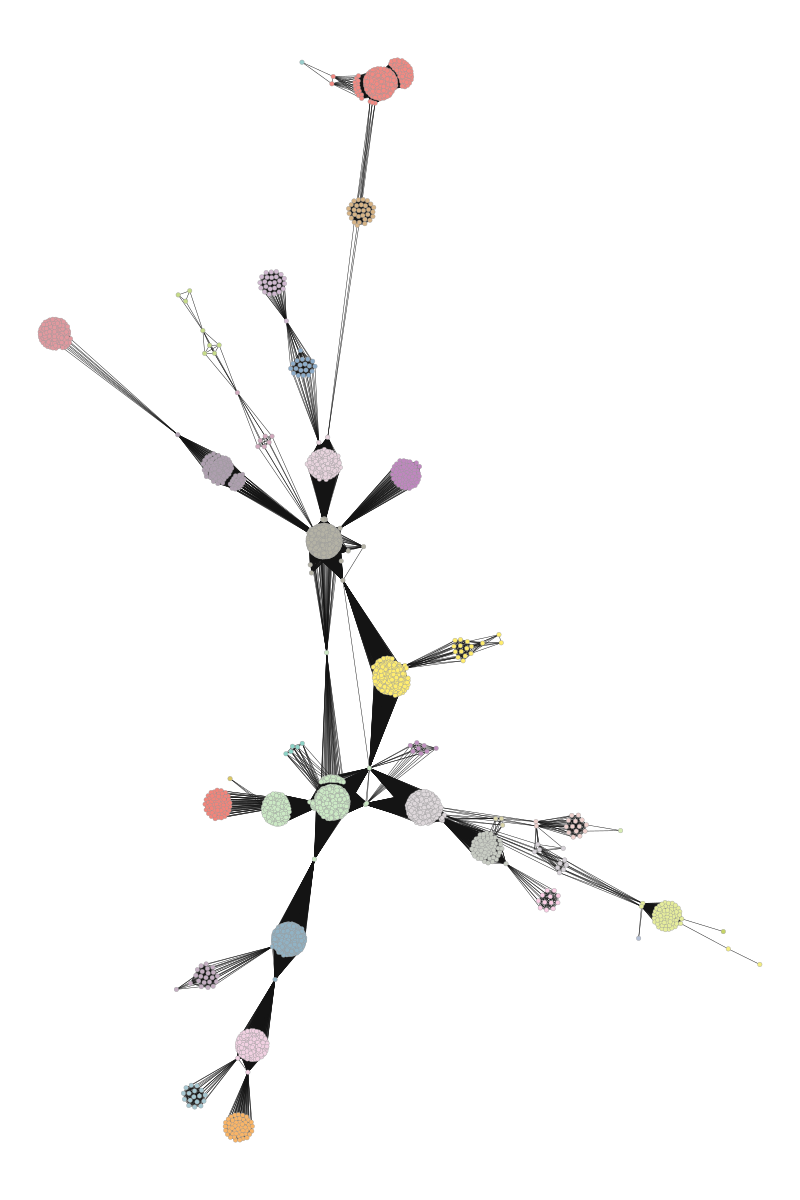

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7faa46057d50, at 0x7faa0435d9d0>

In [30]:
drawBuckets(bucketSetMap)